# Jupiter XIIe Lustrum - Text Analytics

In [78]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

import pandas as pd
import datetime as dt

import nltk
from nltk.probability import FreqDist

import sys
import codecs
import nltk
from nltk.corpus import stopwords

import random
import matplotlib as mpl

from scipy.misc import imread
from wordcloud import WordCloud, STOPWORDS


In [277]:
# Import data Simon since 2013
df = pd.read_table('./data_2013.txt', names=["all"])
#df = pd.read_table('./data_2014.txt', names=["all"]

# Extract date from messages with regex
df['date'] = df['all'].str.extract("(\d{1,2}/\d{2}/\d{2}, \d{2}:\d{2})", expand=True)

# Parse date as datetime. format: 3/25/13, 14:20
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y, %H:%M')

# Extract name and message
df['name'] = df['all'].str.extract("(\d{1,2}/\d{2}/\d{2}, \d{2}:\d{2})( -.*?:)(.*)", expand=True)[1].str[3:-1]
df['message'] = df['all'].str.extract("(\d{1,2}/\d{2}/\d{2}, \d{2}:\d{2})( -.*?:)(.*)", expand=True)[2].str.lower()
df = df.drop('all', 1)

# Include weekday name and hour of day
df['weekday'] = df['date'].dt.weekday_name
df['dayhour'] = df['date'].dt.hour

# Drop missing data 
df = df.dropna()

# Tokenize words
df["tokenized_mess"] = df["message"].apply(nltk.word_tokenize)
df['mess_length'] = df.apply(lambda row: len(row['tokenized_mess']), axis=1)

# Set datatypes
df[['mess_length', 'dayhour']] = df[['mess_length', 'dayhour']].astype(int)
df['weekday'] = df['weekday'].astype('category')

In [262]:
s = "ik vind 😍  😘 matig erg, maar 😂   😜 heel kut en 👍🏽 mag of 💩, rups 🐛 "
s.encode('utf-8')

b'ik vind \xf0\x9f\x98\x8d  \xf0\x9f\x98\x98 matig erg, maar \xf0\x9f\x98\x82   \xf0\x9f\x98\x9c heel kut en \xf0\x9f\x91\x8d\xf0\x9f\x8f\xbd mag of \xf0\x9f\x92\xa9, rups \xf0\x9f\x90\x9b '

In [261]:
df.groupby('name')['loser_cnt'].sum().sort_values(ascending=False)

name
Joost Gerrie van Thiel     1
Joris Schalks              1
‪+31 6 52187656‬           0
Lars ter Braak             0
Bas van der Werf           0
Chris Swinkels             0
David Belgers              0
David Chef Berenstein      0
Frank Rutgers              0
Grote vriendelijke reus    0
Jaap Peterse               0
Job Stiev van Geest        0
Job Visser                 0
Joost Vrijhoef             0
Koen Adje Hendrikse        0
Koen Harthoorn             0
Lester Mateboer            0
‪+31 6 46303872‬           0
Lex Willy van Saane        0
Luc Jacobs                 0
Maarten Simon              0
Maurits Gernaat            0
Max Konings                0
Max Moes Osse              0
Rick van Nobelen           0
Thomas Janssens            0
Timo van Dooremaal         0
Tom Klyn                   0
Werner Hofmeester          0
‪+31 6 14200303‬           0
‪+31 6 14829561‬           0
‪+31 6 21955233‬           0
Arjen Franken              0
Name: loser_cnt, dtype: int64

In [265]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16946 entries, 19 to 24198
Data columns (total 11 columns):
date              16946 non-null datetime64[ns]
name              16946 non-null object
message           16946 non-null object
weekday           16946 non-null category
dayhour           16946 non-null int64
tokenized_mess    16946 non-null object
mess_length       16946 non-null int64
media_cnt         16946 non-null int64
emo_cnt           16946 non-null int64
rups_cnt          16946 non-null int64
loser_cnt         16946 non-null int64
dtypes: category(1), datetime64[ns](1), int64(6), object(3)
memory usage: 1.4+ MB


In [309]:
df[(df['link_cnt'] > 0)]
#df[(df['link_cnt'] > 0) & (df['name'] == 'David Chef Berenstein ')]

,date,name,message,weekday,dayhour,tokenized_mess,mess_length,emo_cnt,rups_cnt,loser_cnt,haha_cnt,media_cnt,sukkel_cnt,link_cnt
3765,2014-08-25 21:19:00,‪+31 6 46303872‬,als iemand de link van het hele filmpje wil: ...,Monday,21,"[als, iemand, de, link, van, het, hele, filmpj...",13,0,0,0,0,0,0,1
7967,2015-02-16 11:08:00,Max Konings,is dit dreas op dumpert?,Monday,11,"[is, dit, dreas, op, dumpert, ?]",6,0,0,0,0,0,0,1
7968,2015-02-16 11:10:00,Frank Rutgers,http://www.dumpert.nl/mediabase/6639977/705cf...,Monday,11,"[http, :, //www.dumpert.nl/mediabase/6639977/7...",3,0,0,0,0,0,0,1
8885,2015-03-31 17:30:00,Rick van Nobelen,dumpert: pech voor de vrouwenboot... - http:/...,Tuesday,17,"[dumpert, :, pech, voor, de, vrouwenboot, ...,...",13,0,0,0,0,0,0,2
13563,2015-10-23 13:16:00,Joost Gerrie van Thiel,mooi op dumpert knallem,Friday,13,"[mooi, op, dumpert, knallem]",4,0,0,0,0,0,0,1
20445,2016-06-21 16:35:00,Max Konings,je bent alleen maar dumpert filmpjes aan het ...,Tuesday,16,"[je, bent, alleen, maar, dumpert, filmpjes, aa...",9,0,0,0,0,0,0,1
20754,2016-06-30 12:28:00,Chris Swinkels,http://www.dumpert.nl/mediabase/6821769/4c80c...,Thursday,12,"[http, :, //www.dumpert.nl/mediabase/6821769/4...",3,0,0,0,0,0,0,1


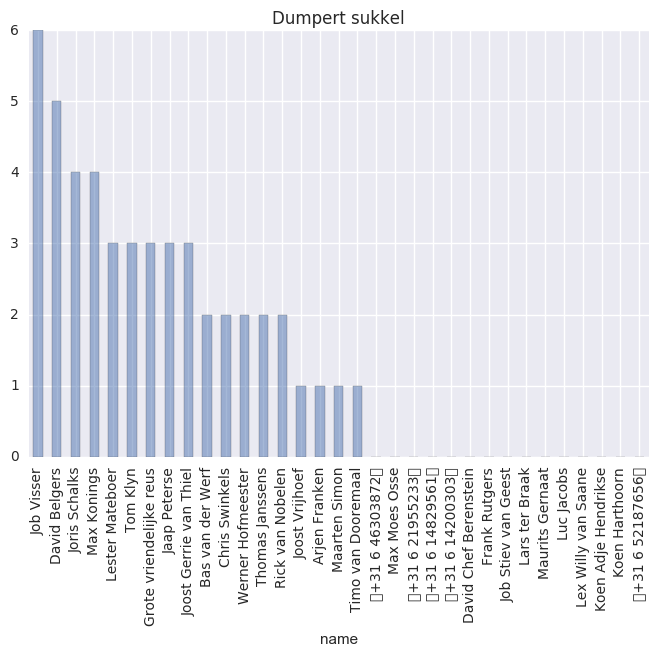

In [311]:
df['emo_cnt'] = df['message'].str.encode('utf-8').str.count(b"(\xf0\x9f)")
df['rups_cnt'] = df['message'].str.encode('utf-8').str.count(b"(\xf0\x9f\x90\x9b)")
df['loser_cnt'] = df['message'].str.encode('utf-8').str.count(b"(\xf0\x9f\x98\x9c)")
df['sukkel_cnt'] = df['message'].str.encode('utf-8').str.count(b"(sukkel+)")
df['link_cnt'] = df['message'].str.encode('utf-8').str.count(b"(dumpert)")

total_emo_cnt(df, 'sukkel_cnt', title = "Sukkel cou")

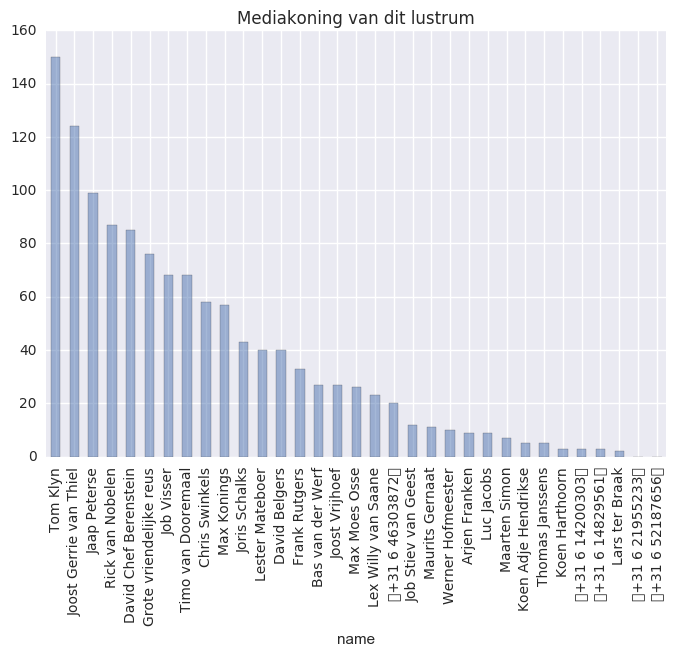

In [283]:
df['media_cnt'] = df['message'].str.count("<media omitted>")
df.groupby('name')['media_cnt'].sum().sort_values(ascending=False).plot.bar(alpha=0.5, title="Mediakoning van dit lustrum")


In [124]:
df.groupby('name').size().\
    sort_values(ascending=False)[2]

1356

In [307]:
def nr_message_plot(df, groupby_col):
    df.groupby(groupby_col).size().\
    sort_values(ascending=False).plot.bar(alpha=0.5, title="Nr. of messages whole group")
    
def total_emo_cnt(df, col, title):
    df.groupby('name')[col].sum().\
    sort_values(ascending=False).plot.bar(alpha=0.5, title=title)

def name_nr_message_plot(df, name, groupby_col):
    df[df['name'] == name].groupby(groupby_col).size().\
    sort_values(ascending=False).plot.bar(alpha=0.5, title="Nr. of messages %s" % name)

def message_length_plot(df):
    df.groupby('name')['mess_length'].mean().sort_values(ascending=False).\
    plot.bar(alpha=0.5, title="Average message length")
    
def name_message_length_plot(df, name, groupby_col):
    df[df['name'] == name].groupby('dayhour')['mess_length'].mean().\
    sort_values(ascending=False).plot.bar(alpha=0.5, title="Average message length %s" % name)    

In [141]:
def name_wordcloud(df, name, verneuk):
    # Join the messages per name 
    if name == 'all':
        dfn = df.groupby(['name'])['message'].apply(lambda x: ','.join(x)).reset_index()
        text = str(dfn['message'].values)
    else:
        dfn = df.groupby(['name'])['message'].apply(lambda x: ','.join(x)).reset_index()
        text = str(dfn.loc[(dfn['name'] == name),'message'].values).lower()
    
    # Verneuk-parameter 
    text = text + (verneuk + ', ')*40
    
    # NLTK's default Dutch stopwords
    default_stopwords = set(nltk.corpus.stopwords.words('dutch'))

    # We're adding some on our own - could be done inline like this...
    custom_stopwords = set((u'omitted', u'media', u'wel', u'even', u'we', u'haha', \
                           u'mee', u'lunch', u'half', u'koffie', u'hoe', u'laat', u'jullie', u'prima'))
    # ... but let's read them from a file instead (one stopword per line, UTF-8)
    #stopwords_file = './stopwords.txt'
    #custom_stopwords = set(codecs.open(stopwords_file, 'r', 'utf-8').read().splitlines())

    all_stopwords = default_stopwords | custom_stopwords

    words = nltk.tokenize.word_tokenize(text)

    # Remove single-character tokens (mostly punctuation)
    words = [word for word in words if len(word) > 1]

    # Remove numbers
    words = [word for word in words if not word.isnumeric()]

    # Lowercase all words (default_stopwords are lowercase too)
    words = [word.lower() for word in words]

    # Stemming words seems to make matters worse, disabled
    # stemmer = nltk.stem.snowball.SnowballStemmer('german')
    # words = [stemmer.stem(word) for word in words]

    # Remove stopwords
    words = [word for word in words if word not in all_stopwords]

    # Calculate frequency distribution
    fdist = nltk.FreqDist(words)

    # Output top 50 words
    #     for word, frequency in fdist.most_common(50):
    #         print(u'{};{}'.format(word, frequency))
    
    # Initialize wordcloud parameters
    limit = 1000
    bgcolor = '#000000'
    fontcolor='#fafafa'
    
    # Generate wordcloud
    wordcloud = WordCloud(
    max_words=limit,
    stopwords=all_stopwords,
    background_color=bgcolor
    ).generate(text)
    
    # Plot wordcloud
    fig = plt.figure()
    fig.set_figwidth(8)
    fig.set_figheight(6)

    plt.imshow(wordcloud.recolor(color_func=grey_color,  random_state=3))

    plt.title("dikke lul", color=fontcolor, size=30, y=1.01)
    plt.axis('off')
    plt.show()

def grey_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return 'hsl(0, 0%%, %d%%)' % random.randint(50, 100)

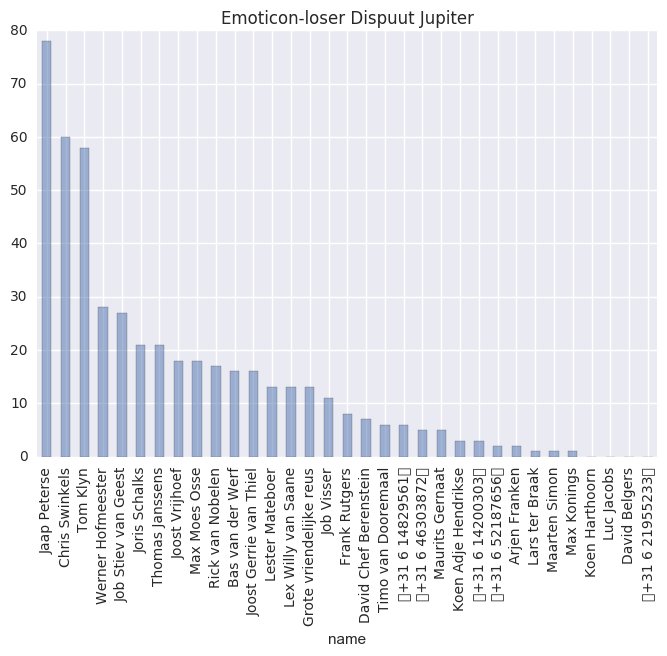

In [248]:
total_emo_cnt(df)

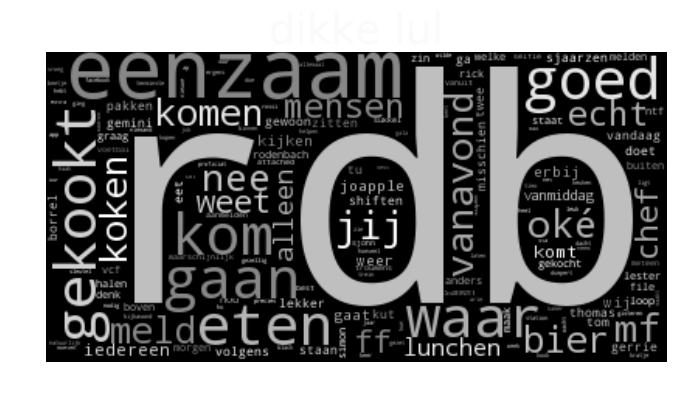

In [267]:
name_wordcloud(df, 'Max Konings', verneuk="eenzaam")

In [117]:
df['name'].unique()

names = ['Job Visser', 'Tom Klyn', 'Timo van Dooremaal',
       'Luc Jacobs', 'Frank Rutgers', 'David Belgers', 'Thomas Janssens',
       'Joost Vrijhoef', 'David Chef Berenstein',
       'Grote vriendelijke reus', 'Joost Gerrie van Thiel',
       'Werner Hofmeester', 'Joris Schalks',
       'Max Konings', 'Arjen Franken', 'Max Moes Osse', 'Rick van Nobelen',
       'Jaap Peterse', 'Lester Mateboer', 'Chris Swinkels']

name_x = names[:5] + 
# Create groups per year

['Job Visser', 'Tom Klyn', 'Timo van Dooremaal', 'Luc Jacobs', 'Frank Rutgers']

In [270]:
g = sns.FacetGrid(df[df['name'].isin(names[:5])], row="weekday", col="name")
g.map(plt.hist , "dayhour", alpha=.7)
g.add_legend();

TypeError: only list-like objects are allowed to be passed to isin(), you passed a [NoneType]

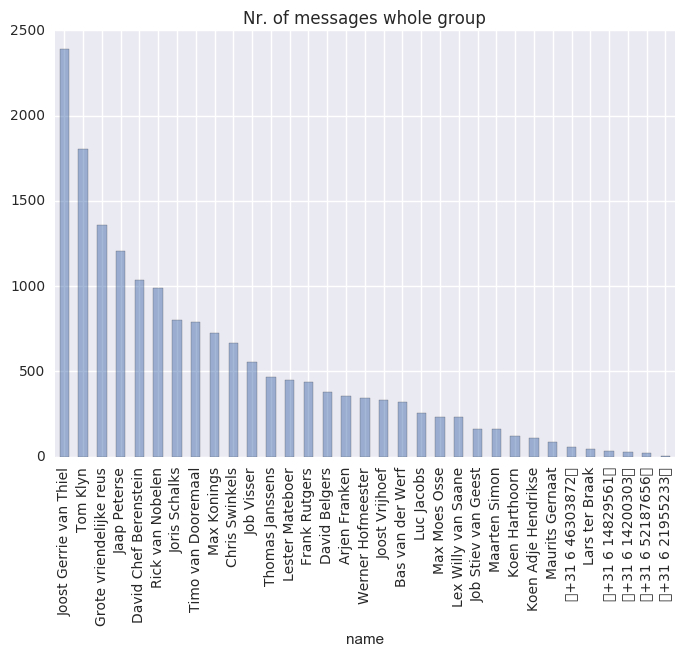

In [130]:
nr_message_plot(df, 'name')

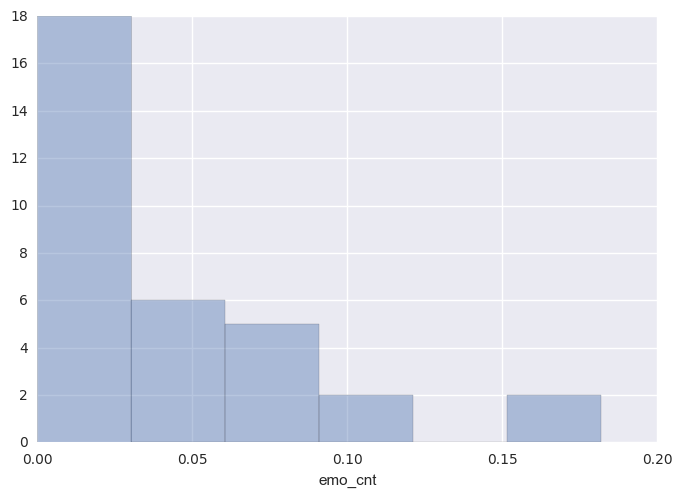

In [244]:
sns.set(color_codes=True)

sns.distplot(df.groupby('name').mean()["emo_cnt"], kde=False, rug=False);

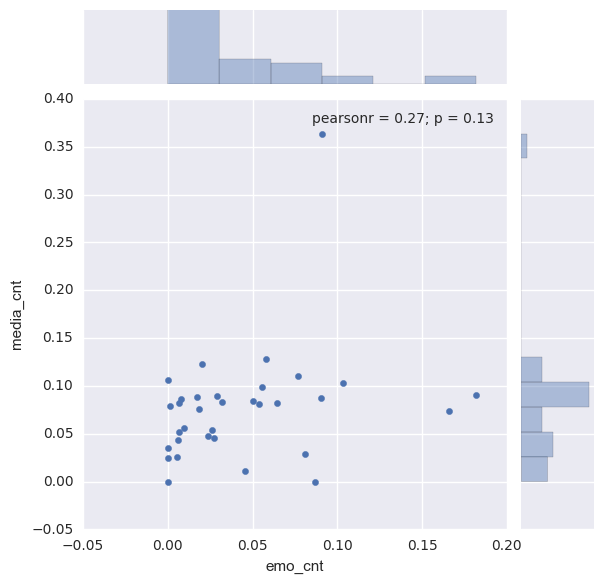

In [241]:
sns.jointplot("emo_cnt", "media_cnt", data=df.groupby('name').mean());


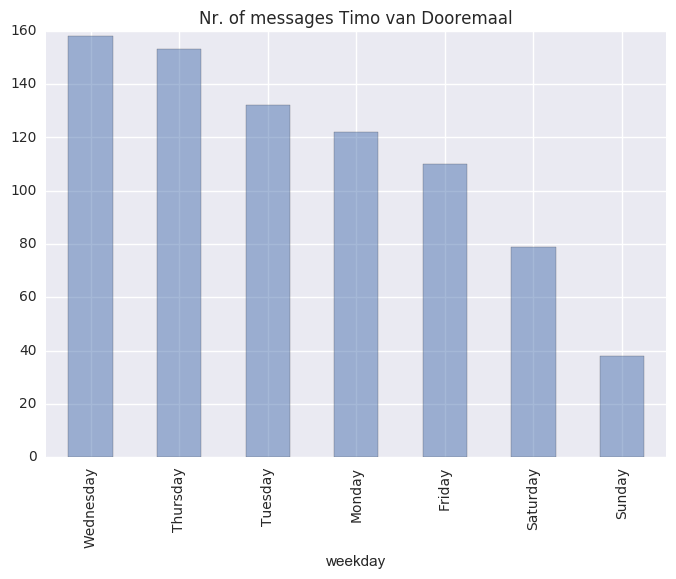

In [134]:
name_nr_message_plot(df, 'Timo van Dooremaal', 'weekday')